In [1]:
import os
import numpy as np
import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
def load_data(base_folder_path,resize=(224,224),test_size=0.2, random_state = 4):
    data=[] #for storing images
    labels=[]   #for storing labels
    path_images = []    #for storing image path
    
    types = sorted(list(os.listdir(base_folder_path)))
    
    #storing images, labels and path 
    for item in types:
        path = sorted(list(os.listdir(base_folder_path+'/'+item)))
        for images in path:
            img_path = base_folder_path+'/'+item+'/'+images
            path_images.append((item,img_path))
            img = cv2.imread(img_path)
            img = cv2.resize(img,resize)
            data.append(img)
            labels.append(item)
    
    #converting images to numpy array and normalizing
    data = np.array(data)
    data = data.astype('float32')/255
    
    #encoding labels
    labels = np.array(labels)
    Lbinary = LabelBinarizer()
    Y = Lbinary.fit_transform(labels)
    
    #for storing labels in dataframe
    enc = []
    for i in range(len(Y)):
        enc.append(' '.join(str(e) for e in Y[i]))
    
    #generating pandas data frame    
    data_df = pd.DataFrame(data=path_images,columns=['items','path'])
    data_df.insert(2,"label encoding",enc,True)
    
    Xs,Ys = shuffle(data,Y)
    X_train,X_test,Y_train,Y_test = train_test_split(Xs,Ys,test_size=test_size,random_state=random_state)
    
    return data_df,X_train,X_test,Y_train,Y_test

In [7]:
from keras.layers import Input, GlobalAveragePooling2D, Dense
from keras.models import Model
#dense net model for transfer learning
def my_Model(base_model,img_row,img_cols,channel,classes):
    
    inputs = Input(shape=(img_row,img_cols,channel))
    x = base_model(inputs,training=False)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(classes,activation='softmax')(x)
    model = Model(inputs,outputs)
    return model

In [9]:
from keras.callbacks import ModelCheckpoint
from keras.applications import DenseNet121
if __name__ == '__main__':
    img_rows, img_cols = 224,224
    channel = 3
    batch_size = 16
    nb_epoch = 10
    
    #loading data
    df,X_train,X_test,Y_train,Y_test = load_data(base_folder_path="cars",resize=(img_rows,img_cols),test_size=0.05,random_state=10)
    
    #loading model
    classes = Y_test.shape[1]
    
    base_model = DenseNet121(include_top=False,weights='imagenet',input_shape=(img_rows,img_cols,channel))
    base_model.trainable = False
    
    model = my_Model(base_model=base_model,img_row=img_rows,img_cols=img_cols,channel=channel,classes=classes)
    
    model.summary()
    model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    
    

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)        │  7,037,504 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_average_pooling2d_1      │ (None, 1024)              │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 7)                 │      7,175 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 7,044,679 (26.87 MB)

 Trainable params: 7,175 (28.03 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=bestmodel.hdf5

In [15]:
    filepath = "{epoch:02d}-{val_loss:.2f}.keras"
    checkpoint = ModelCheckpoint(filepath=filepath,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')
    callbacks_list = [checkpoint]
    history = model.fit(X_train,Y_train,
                        batch_size=batch_size,
                        epochs=nb_epoch,
                        shuffle=True,
                        verbose=1,
                        validation_data=(X_test,Y_test),
                        callbacks=callbacks_list)

Epoch 1/10


2024-01-26 15:57:00.249432: I external/local_xla/xla/service/service.cc:168] XLA service 0x108dfcc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-26 15:57:00.249756: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-01-26 15:57:00.488794: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-26 15:57:01.712187: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-26 15:57:01.829807: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


  3/199 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.0938 - loss: 3.0122    

I0000 00:00:1706266632.516272   53591 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


199/199 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - accuracy: 0.3917 - loss: 1.7017 - val_accuracy: 0.6726 - val_loss: 1.0309
Epoch 2/10
  5/199 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7465 - loss: 0.8546

/home/affan/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:205: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7560 - loss: 0.8011 - val_accuracy: 0.8155 - val_loss: 0.6761
Epoch 3/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8380 - loss: 0.5711 - val_accuracy: 0.8452 - val_loss: 0.5408
Epoch 4/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8562 - loss: 0.4958 - val_accuracy: 0.8631 - val_loss: 0.4766
Epoch 5/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8840 - loss: 0.4184 - val_accuracy: 0.9107 - val_loss: 0.4590
Epoch 6/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9021 - loss: 0.3896 - val_accuracy: 0.9048 - val_loss: 0.4017
Epoch 7/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9107 - loss: 0.3320 - val_accuracy: 0.9048 - val_loss: 0.3727
Epoch 8/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9257 - loss: 0.2913 - val_accuracy: 0.9226 - val_loss: 0.3517
Epoch 9/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9341 - loss: 0.2815 - val_accuracy: 0.922

In [18]:
import matplotlib.pyplot as plt
def plot(history):
    %matplotlib inline
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc)) #No. of epochs
    plt.plot(epochs,acc,'b',label='Training Accuracy')
    plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
    plt.legend()
    plt.figure()

    #Plot training and validation loss per epoch
    plt.plot(epochs,loss,'b',label='Training Loss')
    plt.plot(epochs,val_loss,'r',label='Validation Loss')
    plt.legend()
    plt.show()

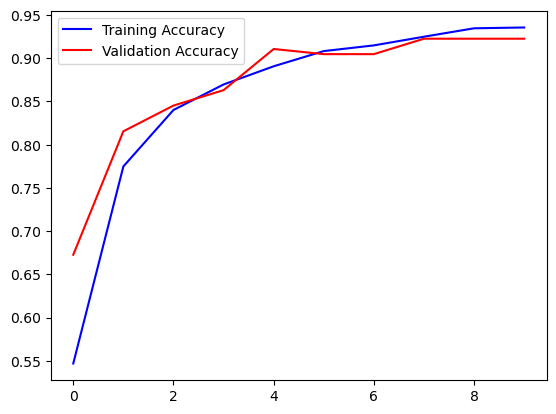

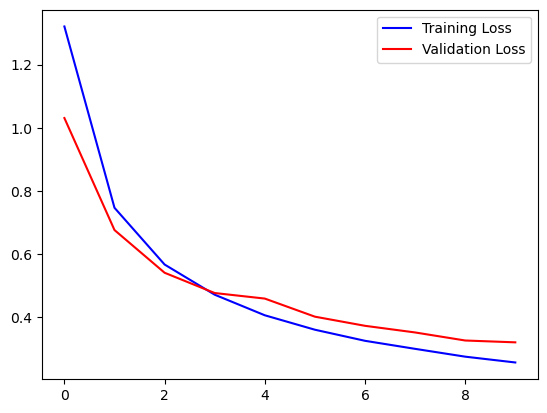

In [19]:
plot(history)

In [41]:
import os
import matplotlib.pyplot as plt

def plot(history):
    %matplotlib inline
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc)) #No. of epochs
    plt.plot(epochs,acc,'b',label='Training Accuracy')
    plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
    plt.legend()
    plt.figure()

    #Plot training and validation loss per epoch
    plt.plot(epochs,loss,'b',label='Training Loss')
    plt.plot(epochs,val_loss,'r',label='Validation Loss')
    plt.legend()
    plt.show()
    
def my_model_evaluation(model,X_test,Y_test):
    xtest=X_test
    ytest=Y_test
    ypred = model.predict(xtest)

    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []

    for i in range(len(ypred)):
        if np.argmax(ypred[i]) == np.argmax(ytest[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)
            
        total += 1
        
    print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
    print('Accuracy:', round(accurate/total*100, 3), '%')
    
    return accurateindex, wrongindex

def my_model_output(dataset_path, accurateindex, wrongindex,correct=True):    
        label=sorted(list(os.listdir(dataset_path)))
        if(correct):
            imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'
        else:
            imidx = random.sample(wrongindex, k=9)# replace with 'wrongindex'
        
        nrows = 3
        ncols = 3
        fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

        n = 0
        for row in range(nrows):
            for col in range(ncols):
                    ax[row,col].imshow(xtest[imidx[n]])
                    ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
                    n += 1

        plt.show()    

In [36]:
accurate_index, wrong_index = my_model_evaluation(model,X_test,Y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Total-test-data; 168 	accurately-predicted-data: 155 	 wrongly-predicted-data:  13
Accuracy: 92.262 %


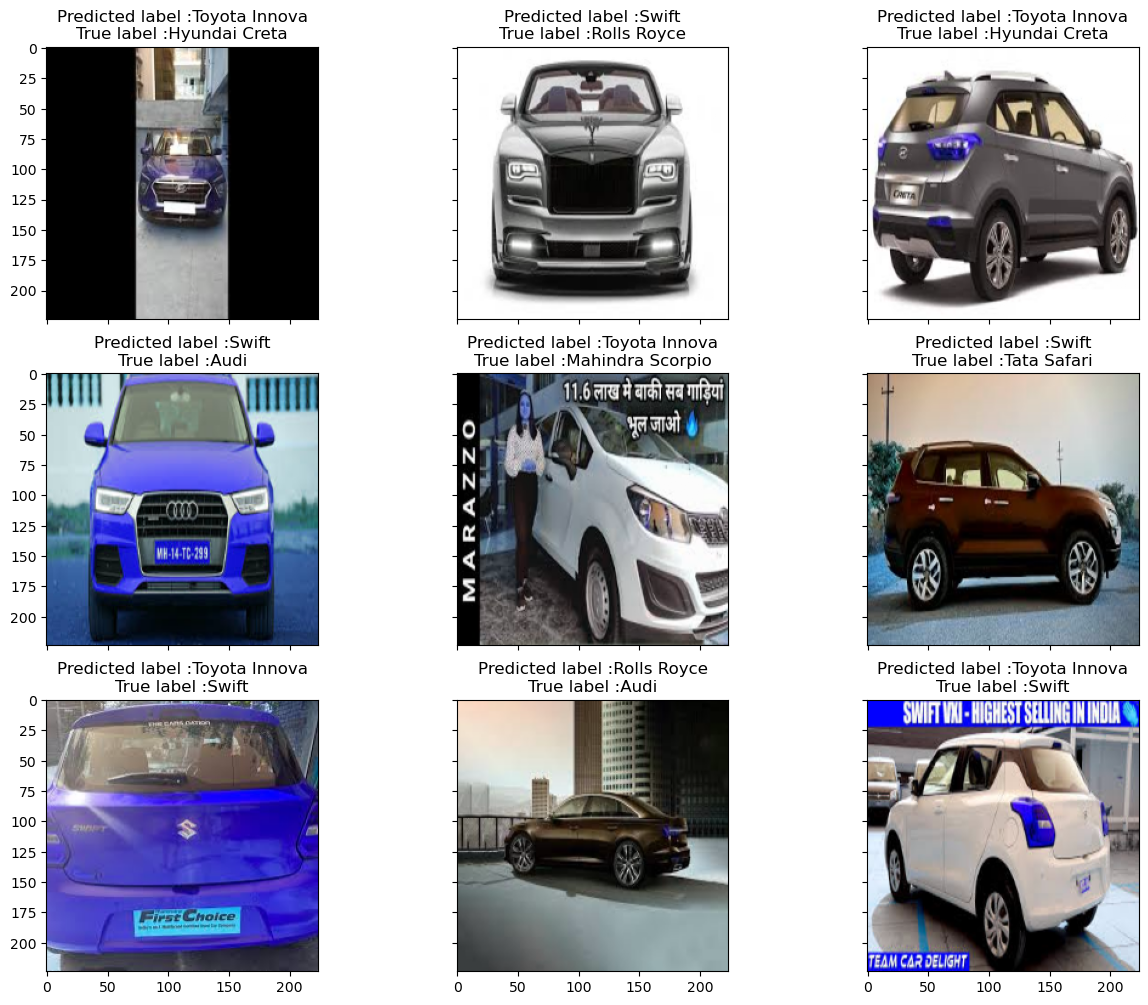

In [42]:
my_model_output("cars", accurate_index, wrong_index,correct=False)